# 0–1 Knapsack with the Bees Algorithm (BA)

Initial installs and lib imports for project...

In [691]:
# install pulp if needed:
# pip install pulp

In [692]:
# --- import necessary libs ---
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import seaborn as sns

## 1. Dataset import - 6 instances

The following files are pared for each instance for Beasley's OR-Library:
<br>
(https://people.brunel.ac.uk/~mastjjb/jeb/orlib/mknapinfo.html)
<br>
- **small 1:** mknapcb1.txt
- **small 2:** mknapcb2.txt
- **medium 1:** mknapcb4.txt
- **medium 2:** mknapcb5.txt
- **large 1:** mknapcb8.txt
- **large 2:** mknapcb9.txt

In [693]:
# --- file paths for all instances ---
# small
MKNAPCB1_PATH = Path("./data/Knapsack/mknapcb1.txt")
MKNAPCB2_PATH = Path("./data/Knapsack/mknapcb2.txt")

# medium
MKNAPCB4_PATH = Path("./data/Knapsack/mknapcb4.txt")
MKNAPCB5_PATH = Path("./data/Knapsack/mknapcb5.txt")

# large
MKNAPCB8_PATH = Path("./data/Knapsack/mknapcb8.txt")
MKNAPCB9_PATH = Path("./data/Knapsack/mknapcb9.txt")

### 1.1 Internal helper functions

Read all rumeric tokens:

In [694]:
def _read_numeric_tokens(path: Path) -> list[float]:
    """Read all numeric tokens from a file (ignore non-numeric)."""
    toks = []
    with open(path, "r") as f:
        for t in f.read().split():
            try:
                toks.append(float(t))
            except ValueError:          # ignore non-numeric artifacts
                pass
    return toks

Parser for all mknapcb OR-Library files. Reads text file describing multiple knapsack problem instances and convert each isnatnce into a pandas `DataFrame`.

In [695]:
def parse_mknapcb_all(path: Path) -> list[pd.DataFrame]:
    """
    Parse all instances from a Beasley mknapcb*.txt file.

    Layout (OR-Library format):
        num_instances
        For each instance:
            n
            capacity m 0
            n profits
            m * n weights
            m capacities

    :param path: path to mknapcb*.txt file
    :return: list of DataFrames, with attrs: m, n, capacities (list[float]), name (str) -> one per instance
    """
    toks = _read_numeric_tokens(path)
    p = 0
    name_base = path.stem.upper()

    if p >= len(toks):
        raise ValueError(f"{path} contains no numeric tokens")

    num_instances = int(toks[p]); p += 1
    dfs: list[pd.DataFrame] = []

    # loop through each instance individually
    for inst in range(num_instances):

        # stop early if file is shorter than declared
        if p + 1 >= len(toks):
            break

        n = int(toks[p]); p += 1
        m = int(toks[p]); p += 1

        # some files have an optional zero right after (header artifact)
        if p < len(toks) and int(toks[p]) == 0:
            p += 1

        # profits
        prof = toks[p:p+n]; p += n
        if len(prof) < n:
            break

        # weights (m x n)
        weights = []
        for _ in range(m):
            row = toks[p:p+n]; p += n
            if len(row) < n:
                break
            weights.append(row)
        if len(weights) < m:
            break

        # capacities (m)
        caps = toks[p:p+m]; p += m
        if len(caps) < m:
            break

        df = pd.DataFrame({"Item": range(1, n + 1), "Profit": prof})
        for j in range(m):
            df[f"Weight_{j+1}"] = weights[j]

        df.attrs.update({
            "m": m,
            "n": n,
            "capacities": caps,
            "name": f"{name_base}#{inst+1}"
        })
        dfs.append(df)

    return dfs

A convenience wrapper for the more general `parse_mknapcb_all()`function. Select only the first instance from each file for the following experiment.

In [696]:
def parse_mknapcb_first(path: Path) -> pd.DataFrame:
    """
    Convenience: return only the first instance from a mknapcb file.

    :param path: path to mknapcb*.txt file
    """
    all_inst = parse_mknapcb_all(path)
    if not all_inst:
        raise ValueError(f"No instances parsed from {path}")
    return all_inst[0]

Produce tabular summaries of all instances parsed:

In [697]:
def tables(top_n: int = 10) -> dict[str, pd.DataFrame]:
    """
    Load the first instance from each selected mknapcb file,
    print a short summary, and return them in a dictionary.

    :param top_n: number of rows to print from each df  (default: 10)
    :return: datasets: dictionary mapping dataset names (str) -> pd.DataFrame
    """
    small_1 = parse_mknapcb_first(MKNAPCB1_PATH)
    small_2 = parse_mknapcb_first(MKNAPCB2_PATH)

    medium_1 = parse_mknapcb_first(MKNAPCB4_PATH)
    medium_2 = parse_mknapcb_first(MKNAPCB5_PATH)

    large_1 = parse_mknapcb_first(MKNAPCB8_PATH)
    large_2 = parse_mknapcb_first(MKNAPCB9_PATH)

    datasets = {
        "small_1": small_1,
        "small_2": small_2,
        "medium_1": medium_1,
        "medium_2": medium_2,
        "large_1": large_1,
        "large_2": large_2,
    }

    # print summaries + top N rows
    for label, df in datasets.items():
        print(f"\n=== {label} ===")
        print(f"{df.attrs['name']}: {df.attrs['n']} items, {df.attrs['m']} constraints")
        print("Capacities:", df.attrs["capacities"])
        print(df.head(top_n))

    return datasets


# save tables as ds
ds = tables(top_n=10)
ds["small_1"].describe()


=== small_1 ===
MKNAPCB1#1: 100 items, 5 constraints
Capacities: [11927.0, 13727.0, 11551.0, 13056.0, 13460.0]
   Item  Profit  Weight_1  Weight_2  Weight_3  Weight_4  Weight_5
0     1   504.0      42.0     509.0     806.0     404.0     475.0
1     2   803.0      41.0     883.0     361.0     197.0      36.0
2     3   667.0     523.0     229.0     199.0     817.0     287.0
3     4  1103.0     215.0     569.0     781.0    1000.0     577.0
4     5   834.0     819.0     706.0     596.0      44.0      45.0
5     6   585.0     551.0     639.0     669.0     307.0     700.0
6     7   811.0      69.0     114.0     957.0      39.0     803.0
7     8   856.0     193.0     727.0     358.0     659.0     654.0
8     9   690.0     582.0     491.0     259.0      46.0     196.0
9    10   832.0     375.0     481.0     888.0     334.0     844.0

=== small_2 ===
MKNAPCB2#1: 250 items, 5 constraints
Capacities: [29562.0, 30027.0, 32082.0, 31340.0, 29959.0]
   Item  Profit  Weight_1  Weight_2  Weight_3  Wei

,Item,Profit,Weight_1,Weight_2,Weight_3,Weight_4,Weight_5
count,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,768.42000,477.070000,549.070000,462.030000,522.220000,538.400000
std,29.011492,173.26235,293.753427,266.410644,292.447576,297.945408,276.054416
min,1.000000,388.00000,41.000000,32.000000,4.000000,13.000000,25.000000
25%,25.750000,631.50000,217.250000,295.250000,197.250000,277.250000,335.750000
50%,50.500000,797.50000,471.500000,588.000000,409.000000,519.500000,579.500000
75%,75.250000,868.00000,732.000000,779.250000,744.750000,783.000000,759.750000
max,100.000000,1169.00000,998.000000,967.000000,973.000000,1000.000000,995.000000


### 1.2 Capacities for each instance

Plot bar chart of capacity limits for each constraint in a knapsack instance.

In [698]:
# --- helper function for plot_all_datasets ---
def plot_capacities(df, title_prefix=""):
    """
    Create bar chart for selected instances to display capacities of the knapsacks.

    :param df:              pandas DataFrame with instances
    :param title_prefix:    prefix for instance (instance identifier)
    """
    caps = np.array(df.attrs["capacities"], dtype=float)
    plt.figure()
    plt.bar(np.arange(len(caps)) + 1, caps, color="salmon")
    plt.title(f"{title_prefix}Constraint resource limits".strip())
    plt.xlabel("Constraint index")
    plt.ylabel("Capacity")

def plot_all_datasets(datasets, show=True, save_dir=None, bins=40):
    """
    Creates and displays plot profit histograms and capacities for all instances.

    :param: datasets: dict like {"medium_1": df, "medium_2": df, "large_1": df} - data with all instances
    :param: show:     call plt.show() at the end    (default: True)
    :param: save_dir: directory to save PNGs        (default: None)
    :param: bins:     histogram bins for profits    (default: 40)
    """
    save_dir = Path(save_dir) if save_dir else None
    if save_dir:
        save_dir.mkdir(parents=True, exist_ok=True)

    for label, df in datasets.items():
        prefix = f"{label} — "

        # profit histogram
        plt.figure()
        plt.hist(df["Profit"], bins=bins, color="skyblue", edgecolor="black")
        plt.title(f"{prefix}Distribution of item profits")
        plt.xlabel("Profit / Value")
        plt.ylabel("Frequency")
        if save_dir:
            plt.savefig(save_dir / f"{label}_profit_hist.png", bbox_inches="tight")

        # capacities bar plot
        plot_capacities(df, title_prefix=prefix)
        if save_dir:
            plt.savefig(save_dir / f"{label}_capacities.png", bbox_inches="tight")

    if show:
        plt.show()

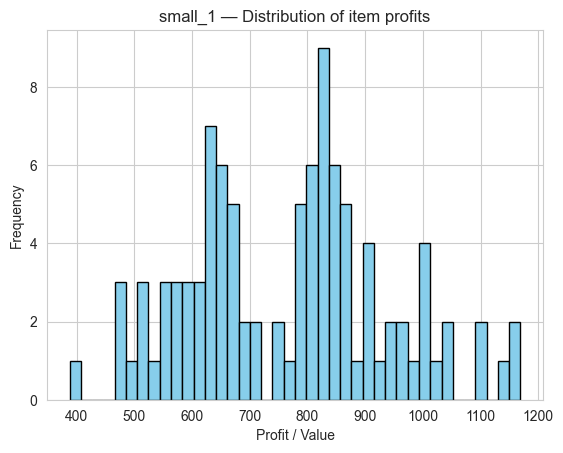

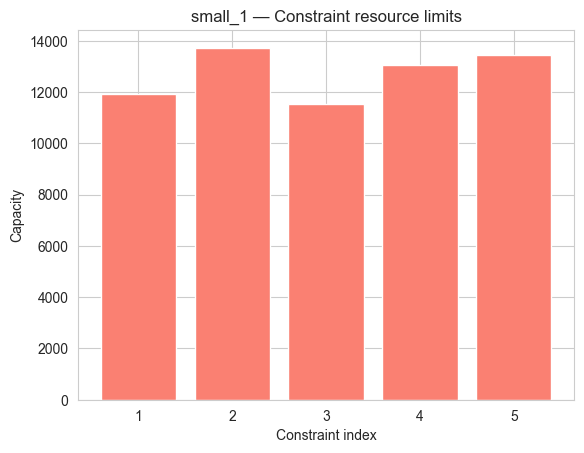

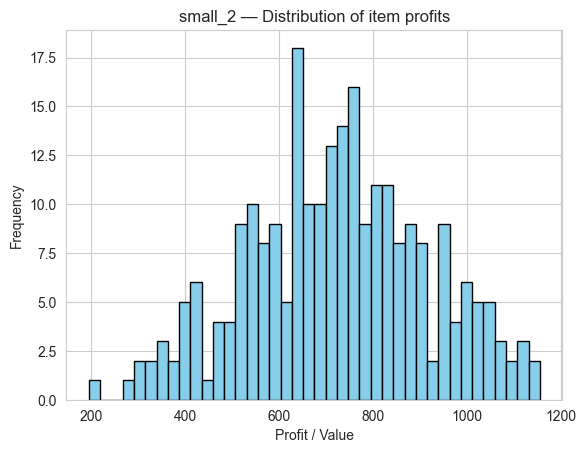

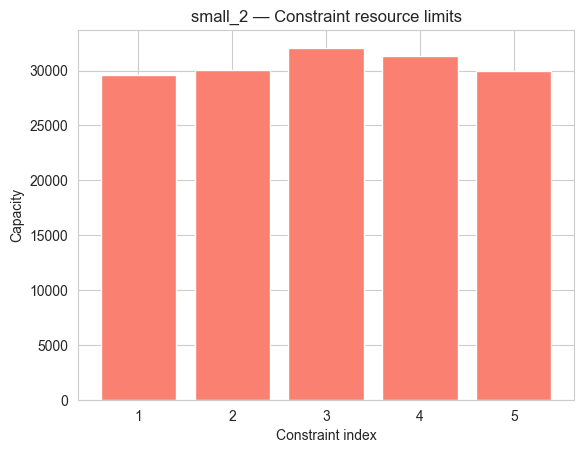

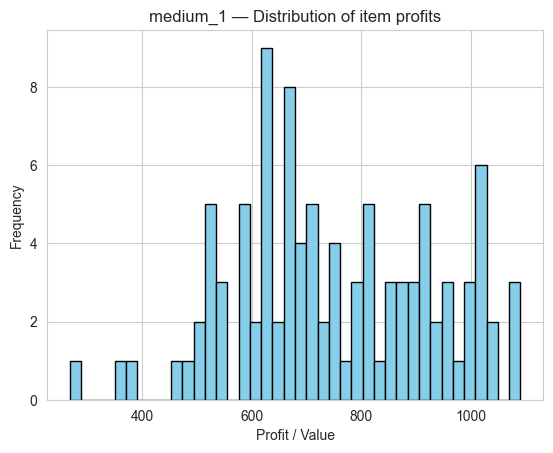

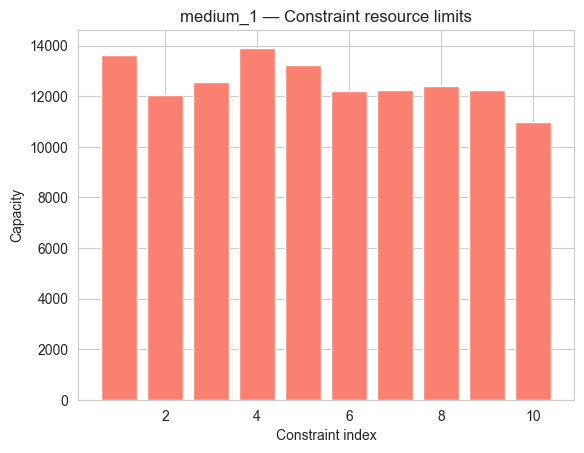

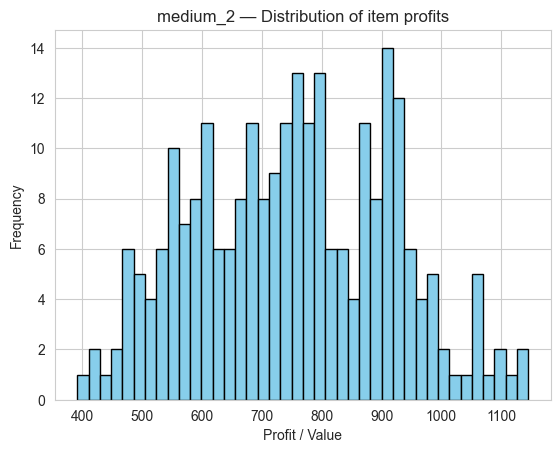

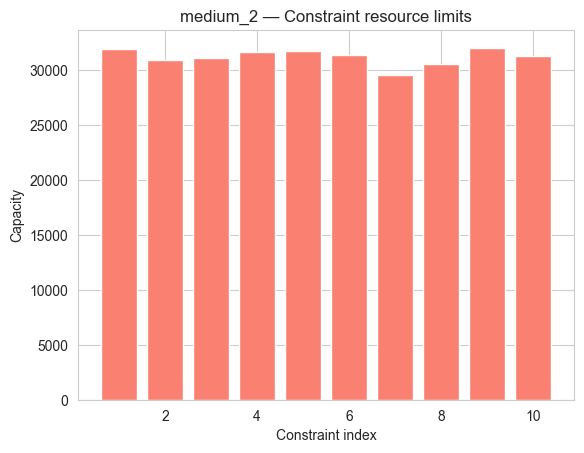

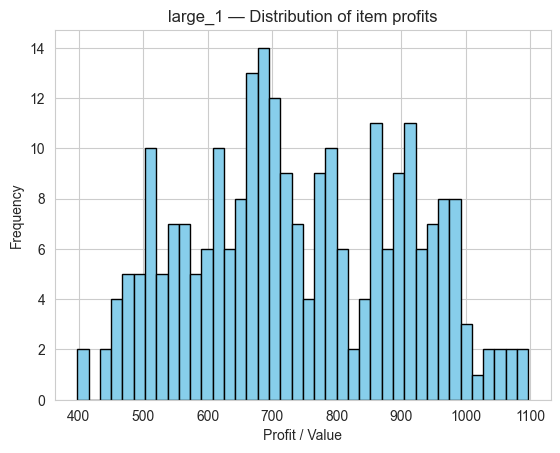

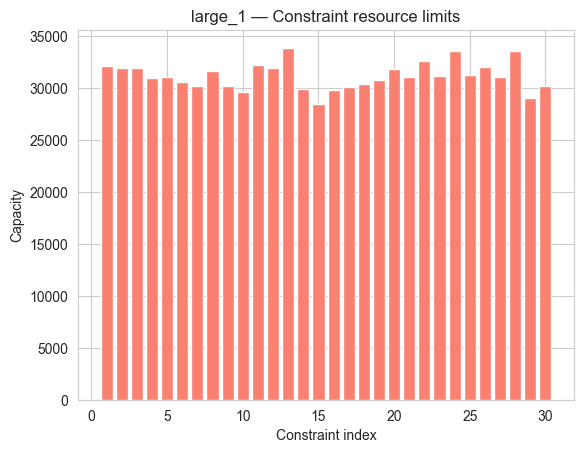

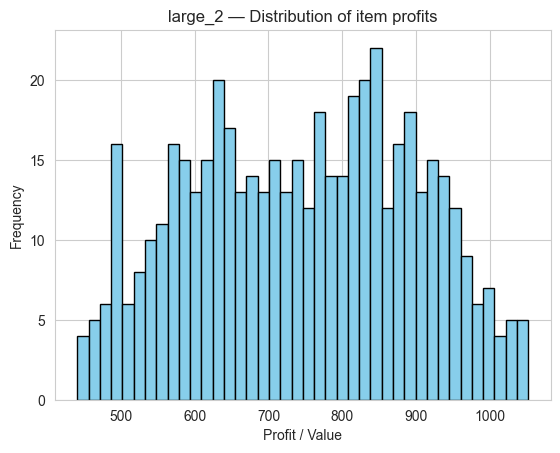

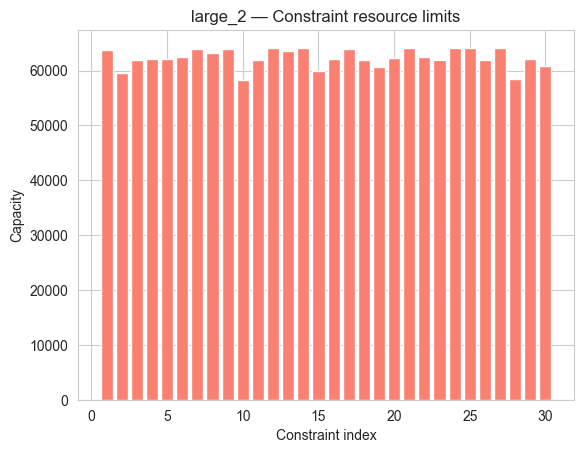

In [699]:
# --- plot profit/value of items in instance + capacities per instance ---
plot_all_datasets(ds)


## 2. Define parameters and instance

In [700]:
# --- map instances to tables ---
instances = {
    "small_1": ds["small_1"],
    "small_2": ds["small_2"],
    "medium_1": ds["medium_1"],
    "medium_2": ds["medium_2"],
    "large_1": ds["large_1"],
    "large_2": ds["large_2"]
}

# pick instances to run
experiment_instances = {
    "small_1": instances["small_1"],
    "small_2": instances["small_2"],
    "medium_1": instances["medium_1"],
    "medium_2": instances["medium_2"],
    "large_1":  instances["large_1"],
    "large_2":  instances["large_2"]
}

In [701]:
#--- define 3 BA parameter sets ---
# balanced parameter set
params_balanced = {
    "n": 80,        # number of scout bees
    "nb": 20,       # number of best sites selected
    "ne": 5,        # number of elite sites
    "nre": 15,      # recruited bees around elite sites
    "nrb": 7,       # recruited bees around other best sites
    "ngh": 3,       # neighbourhood size (bits flipped)
    "stlim": 35,    # stagnation limit - stops iterations if no progress is made for x iterations
    "max_iter": 500
}

# explorative parameter set
params_exploration = {
    "n": 100,        # explore more of the search space
    "nb": 20,
    "ne": 5,
    "nre": 15,
    "nrb": 15,      # explore more around other best sites
    "ngh": 8,       # explore wider neighbourhoods
    "stlim": 35,
    "max_iter": 500
}

# exploitive parameter set
params_exploitation = {
    "n": 60,        # smaller population, more focused
    "nb": 20,
    "ne": 5,
    "nre": 25,      # more recruited bees = deeper local search
    "nrb": 7,
    "ngh": 3,
    "stlim": 35,
    "max_iter": 500
}

# --- combine into a single dictionary for experiments ---
parameter_sets = {
    "baseline": params_balanced,
    "exploration": params_exploration,
    "exploitation": params_exploitation
}


# --- known optimal values collected from mkcbres.txt from OR-Library -> for solution evaluation ---
known_optima = {
    "small_1": 24381,
    "small_2": 59312,
    "medium_1": 23064,
    "medium_2": 59187,
    "large_1": 56693,
    "large_2": 115868
}

## 3. The Bees Algorith (BA) on multi-knapsack problem

In [702]:
def bees_knapsack_mkp(values, W, b, n, nb, ne, nre, nrb, ngh, max_iter, stlim):
    """
    Metaheuristic optimization technique (Bees Algorithm) to solve the multi-contraint knapsack problem

    Repair strategy: removes lowest-value items until all capacity constraints are satisfied
    Stop criteria: terminates after `max_iter` iterations or when no improvement occurs over successive iterations

    :param: values :        array_like      -> resource usage matrix (m x n_items)
    :param: W :             array_like      -> capacity limits for each resource
    :param: b :             array_like      -> capacity limits for each resource
    :param: n :             int             -> number of scout bees (population size)
    :param: nb :            int             -> number of best sites selected for neighborhood search
    :param: ne :            int             -> number of elite sites
    :param: nre :           int             -> number of recruited bees per elite site
    :param: nrb :           int             -> number of recruited bees around each non-elite best site
    :param: ngh :           int             -> neighborhood size (bit flips per neighbor)
    :param: max_iter:       int             -> maximum number of iterations (generations)

    :return: best_value:    float           -> the best objective value found
    :return: best_solution: ndarray         -> binary vector of selected items
    :return: hist_best:     list of float   -> the best fitness per iteration
    :return: hist_avg:      list of float   -> average fitness per iteration
    :return: iter_of_best:  int             -> iteration when best solution found
    :return: runtime:       float           -> total execution time (seconds)
    """
    start = time.time()

    # convert to NumPy arrays for fast vectorized math
    values = np.asarray(values, float)
    W = np.asarray(W, float)
    b = np.asarray(b, float)

    # record shape of W ( m constraints, n items)
    m, n_items = W.shape

    norm_W = W / (b[:, None] + 1e-12)
    item_density = norm_W.sum(axis=0)
    profit_per_density = values / (item_density + 1e-12)


    # --- helper functions ---
    def is_feasible(x):
        """
        Feasible if the total weights per constraint don't exceed capacities.
        """
        return np.all(W @ x <= b + 1e-12)

    def repair(x):
        """
        Repair function -> greedy drop: remove items with the smallest profit_per_density until feasible.
        """
        x = x.copy()
        while True:
            totals = W @ x
            if np.all(totals <= b + 1e-12): break
            ones = np.where(x == 1)[0]
            if ones.size == 0: break
            worst = ones[np.argmin(profit_per_density[ones])]
            x[worst] = 0
        return x

    def fitness_of(x):
        """
        Evaluate fitness of solution.
        Fitness value = total profit.

        (Possibly repaired solution if it was infeasible)
        """
        if not is_feasible(x): x = repair(x)
        return float(values @ x), x


    # --- initialize population ---
    population = np.random.randint(0, 2, (n, n_items))
    fitness = np.zeros(n)
    for i in range(n):
        val, fx = fitness_of(population[i])
        population[i], fitness[i] = fx, val

    baseline_best = float(np.max(fitness))

    best_idx = int(np.argmax(fitness))
    best_value = float(fitness[best_idx])
    best_solution = population[best_idx].copy()
    iter_of_best = 0

    hist_best = [best_value]        # track global best
    hist_avg  = [float(np.mean(fitness))]

    # stagnation check (for stlim)
    no_improve_count = 0
    last_best = best_value


    # --- main BA loop ---
    for it in range(1, max_iter + 1):

        # sort population -> best to worst
        order = np.argsort(fitness)[::-1]
        population, fitness = population[order], fitness[order]

        new_population, new_fitness = [], []

        # neighbourhood search
        for i in range(nb):
            site = population[i].copy()
            recruits = nre if i < ne else nrb
            best_site_val = float(fitness[i])
            best_site_sol = site.copy()

            # explore neighbours
            for _ in range(recruits):
                neigh = site.copy()
                flips = np.random.randint(1, min(ngh, n_items) + 1)
                idx = np.random.choice(n_items, size=flips, replace=False)
                neigh[idx] = 1 - neigh[idx]
                val, neigh = fitness_of(neigh)
                if val > best_site_val:
                    best_site_val, best_site_sol = float(val), neigh.copy()

            # add best neighbour to new population
            new_population.append(best_site_sol)
            new_fitness.append(best_site_val)

        # add scout bees
        scouts = np.random.randint(0, 2, (n - nb, n_items))

        for s in scouts:
            val, s = fitness_of(s)
            new_population.append(s)
            new_fitness.append(float(val))

        population = np.array(new_population)
        fitness = np.array(new_fitness, float)

                # update global best
        improved = False
        current_best_idx = np.argmax(fitness)
        current_best_value = fitness[current_best_idx]

        if current_best_value > best_value + 1e-9:
            best_value = float(current_best_value)
            best_solution = population[current_best_idx].copy()
            iter_of_best = it
            no_improve_count = 0
            improved = True
        else:
            no_improve_count += 1

        # early stopping check
        if no_improve_count >= stlim:
            break

        hist_best.append(best_value)
        hist_avg.append(float(np.mean(fitness)))

    runtime = time.time() - start

    return baseline_best, best_value, best_solution, hist_best, hist_avg, iter_of_best, runtime


## 4. Run experiment

Run BA on all 6 instances for each of the 3 parameter sets. 20 runs for each instance to trach means and avoid evaluating on outliers.
<br>
##### Columns in output table:
- `Seed`: seed for run
- `Instance`: instance for
- `Items`: num of knapsack items available for the instance
- `Constraints`: num of knapsack constraints for the instance
- `Parameter_Set`: the parameter set used for the run
- `Best_Value`: best value found for the run
- `Optimal_Value`: known optimal value for the instance
- `Deviation_%`: the deviation of best value from known optimal value
- `Runtime_s`: runtime for the run in seconds
- `Iterations`: number of iterations
- `Iter_of_Best`: iteration where best value was found
- `Used_Weight`: weights used
- `Hist_Best`: historical best values from the run
- `Hist_Avg`: historical averages from the run

In [703]:
def run_experiment_multi(instances, parameter_sets, seeds=range(20)):
    """
    Run Bees Algorithm across multiple MKP instances and parameter sets.
    Includes comparison with known optima when available.

    :param instances:       dict of problem instances (DataFrames)
    :param parameter_sets:  dict of parameter configurations
    :param seeds:           iterable of random seeds
    :return: pd.DataFrame:  all experiment results
    """
    rows = []

    # --- for each parameter (3) ---
    for param_label, params in parameter_sets.items():
        print(f"\nRunning parameter set: {param_label}")

        # --- for each instance (6) ---
        for inst_label, df in instances.items():
            print(f"Instance: {inst_label} ({df.attrs['n']} items, {df.attrs['m']} constraints)")

            values = df["Profit"].to_numpy(float)
            W = np.vstack([df[c].to_numpy(float) for c in df.columns if c.startswith("Weight_")])
            b = np.array(df.attrs["capacities"], float)

            # known optimum lookup
            opt = known_optima.get(inst_label, df.attrs.get("optimal_value", None))
            if opt is not None:
                print(f"Known optimum: {opt}")
            else:
                print(f"No known optimum available.")

            # --- for each seed (20) ---
            for seed in seeds:
                np.random.seed(seed)
                baseline, best, sol, h_best, h_avg, it_best, rt = bees_knapsack_mkp(values, W, b, **params)
                totals = (W @ sol).tolist()
                iterations = len(h_best) - 1

                # deviation from known optimum
                deviation = (
                    np.nan if (opt is None or not np.isfinite(opt) or opt == 0)
                    else 100 * (1 - best / opt)
                )

                # improvement (%) from baseline to best
                improvement = 100 * (1 - baseline / best)

                rows.append({
                    "Seed": seed,
                    "Instance": inst_label,
                    "Items": int(df.attrs["n"]),
                    "Constraints": int(df.attrs["m"]),
                    "Parameter_Set": param_label,
                    "Baseline_Best": float(baseline),
                    "Best_Value": float(best),
                    "Improvement": improvement,
                    "Optimal_Value": (None if opt is None else float(opt)),
                    "Deviation_%": deviation,
                    "Runtime_s": rt,
                    "Iterations": iterations,
                    "Iter_of_Best": it_best,
                    "Used_Weight": totals,
                    "Hist_Best": h_best,
                    "Hist_Avg": h_avg,
                })

                # print progress
                dev_str = "N/A" if np.isnan(deviation) else f"{deviation:.2f}%"
                improve_str = "N/A" if np.isnan(improvement) else f"{improvement:.2f}%"
                print(f"    Seed {seed:02d}: Baseline={baseline:.2f}, Best={best:.2f}, Improvement={improve_str}, Opt={opt}, Dev={dev_str}, Iterations={iterations}, Time={rt:.2f}s")

    print("\nAll experiments completed.")

    return pd.DataFrame(rows)



The following runs the experiment, which can be timely. The output is a dataframe (`multi_df`) that includes all results from each run.

In [705]:
# run experiment
multi_df = run_experiment_multi(experiment_instances, parameter_sets, seeds=range(20))


Running parameter set: baseline
Instance: small_1 (100 items, 5 constraints)
Known optimum: 24381
    Seed 00: Baseline=21653.00, Best=23572.00, Improvement=8.14%, Opt=24381, Dev=3.32%, Iterations=49, Time=0.65s
    Seed 01: Baseline=21977.00, Best=23912.00, Improvement=8.09%, Opt=24381, Dev=1.92%, Iterations=113, Time=1.57s
    Seed 02: Baseline=21763.00, Best=23901.00, Improvement=8.95%, Opt=24381, Dev=1.97%, Iterations=57, Time=0.70s
    Seed 03: Baseline=21563.00, Best=23897.00, Improvement=9.77%, Opt=24381, Dev=1.99%, Iterations=97, Time=1.18s
    Seed 04: Baseline=21986.00, Best=23531.00, Improvement=6.57%, Opt=24381, Dev=3.49%, Iterations=63, Time=0.77s
    Seed 05: Baseline=22189.00, Best=23845.00, Improvement=6.94%, Opt=24381, Dev=2.20%, Iterations=70, Time=0.87s
    Seed 06: Baseline=21773.00, Best=23769.00, Improvement=8.40%, Opt=24381, Dev=2.51%, Iterations=62, Time=0.77s
    Seed 07: Baseline=21870.00, Best=23795.00, Improvement=8.09%, Opt=24381, Dev=2.40%, Iterations=97,

## 5. Experiment Results

### 5.1 Combining experiment results into one aggregated table (mean/std between seeds)
<br>


In [734]:
def run_experiment(multi_df):
    """
    Aggregate experiment results (multi_df) into one row per Instance × Parameter_Set.

    Computes:
    - baseline_mean = mean baseline best
    - best_mean = mean best value
    - runtime_mean = mean runtime
    - deviation_mean = mean deviation from optimum value
    - deviation_min = minimum deviation from optimum value
    - deviation_max = maximum deviation from optimum value
    - runtime_min = minimum runtime
    - runtime_max = maximum runtime
    - iter_mean = mean number of iterations
    - iter_best_mean = mean number of iterations when best value was found
    - hist_best_mean = elementwise mean (list)
    - hist_avg_mean = elementwise mean (list)

    :param multi_df: pd.DataFrame of results of all 20 seeds of experiment
    :return: pd.DataFrame of aggregated results of experiment
    """

    import numpy as np
    import pandas as pd

    def mean_list(list_series):
        """Compute elementwise mean of lists (histories) across seeds."""
        valid = [np.asarray(x, dtype=float) for x in list_series if isinstance(x, (list, np.ndarray))]
        if not valid:
            return []
        min_len = min(len(lst) for lst in valid)
        arr = np.vstack([lst[:min_len] for lst in valid])
        return arr.mean(axis=0).tolist()

    results = []

    grouped = multi_df.groupby(["Instance", "Parameter_Set"], dropna=False)

    for (inst_label, param_label), group in grouped:
        baseline_mean = group["Baseline_Best"].mean()
        best_mean = group["Best_Value"].mean()
        runtime_mean = group["Runtime_s"].mean()
        deviation_mean = group["Deviation_%"].mean()
        deviation_min = group["Deviation_%"].min()
        deviation_max = group["Deviation_%"].max()
        runtime_min = group["Runtime_s"].min()
        runtime_max = group["Runtime_s"].max()
        iter_mean = group["Iterations"].mean()
        iter_best_mean = group["Iter_of_Best"].mean()

        # Histories (elementwise mean)
        hist_best_mean = mean_list(group["Hist_Best"])
        hist_avg_mean = mean_list(group["Hist_Avg"])

        # Improvement based on aggregated means
        improvement = 100 * (best_mean - baseline_mean) / baseline_mean

        results.append({
            "Instance": inst_label,
            "Parameter_Set": param_label,
            "Baseline_Best": round(baseline_mean, 2),
            "Best_Value": round(best_mean, 2),
            "Improvement": round(improvement, 2),
            "Deviation_%": round(deviation_mean, 2),
            "Deviation_min": round(deviation_min, 2),
            "Deviation_max": round(deviation_max, 2),
            "Runtime_s": round(runtime_mean, 2),
            "Runtime_min": round(runtime_min, 2),
            "Runtime_max": round(runtime_max, 2),
            "Iterations": round(iter_mean, 2),
            "Iter_of_Best": round(iter_best_mean, 2),
            "Hist_Best": hist_best_mean,
            "Hist_Avg": hist_avg_mean,
        })

    results_df = pd.DataFrame(results)
    return results_df


Create aggregated experiment results list:

In [737]:
# run multi_df -> results_df
results_df = run_experiment(multi_df)
results_df

,Instance,Parameter_Set,Baseline_Best,Best_Value,Improvement,Deviation_%,Deviation_min,Deviation_max,Runtime_s,Runtime_min,Runtime_max,Iterations,Iter_of_Best,Hist_Best,Hist_Avg
0,large_1,baseline,51493.85,54695.55,6.22,3.52,2.95,4.41,3.11,1.81,6.01,98.95,64.95,"[51493.85, 52105.85, 52365.85, 52744.7, 52884....","[48314.92187499999, 48786.51874999999, 48939.4..."
1,large_1,exploitation,51483.15,54861.55,6.56,3.23,2.53,4.48,3.95,1.82,7.35,127.30,93.30,"[51483.15, 52162.95, 52506.6, 52767.55, 53018....","[48331.901666666665, 48974.546666666654, 49213..."
2,large_1,exploration,51557.50,54988.10,6.65,3.01,2.17,3.75,5.30,2.41,11.99,112.15,78.15,"[51557.5, 52322.8, 52663.25, 52925.4, 53131.3,...","[48272.302500000005, 48836.01950000001, 48862...."
3,large_2,baseline,105102.00,111649.15,6.23,3.64,2.85,5.02,13.45,5.35,22.58,185.75,151.75,"[105102.0, 105973.5, 106482.8, 106891.15, 1070...","[100764.19874999998, 101505.38249999999, 10173..."
4,large_2,exploitation,104922.65,111729.20,6.49,3.57,2.96,4.30,10.98,5.67,18.14,154.40,120.40,"[104922.65, 105725.65, 106143.5, 106537.05, 10...","[100758.86166666663, 101623.62999999999, 10186..."
5,large_2,exploration,105351.25,112322.95,6.62,3.06,2.21,3.67,21.91,7.94,37.57,211.75,177.75,"[105351.25, 106192.0, 106664.1, 107100.8, 1072...","[100773.30299999999, 101488.9745, 101643.35199..."
6,medium_1,baseline,20779.45,22390.45,7.75,2.92,1.53,3.91,1.04,0.50,1.66,81.20,47.20,"[20779.45, 21238.85, 21406.2, 21579.75, 21726....","[18806.850000000002, 19162.721874999996, 19229..."
7,medium_1,exploitation,20757.00,22400.60,7.92,2.88,1.99,4.01,0.90,0.51,1.87,80.15,46.15,"[20757.0, 21231.45, 21476.5, 21698.35, 21815.1...","[18805.144166666665, 19299.3225, 19423.9583333..."
8,medium_1,exploration,20885.85,22510.90,7.78,2.40,0.93,3.06,1.52,0.94,2.40,72.75,38.75,"[20885.85, 21323.55, 21548.55, 21719.8, 21849....","[18825.081500000004, 19180.01, 19249.978, 1927..."
9,medium_2,baseline,52933.10,57128.55,7.93,3.48,2.30,4.95,3.04,1.68,5.14,113.95,79.95,"[52933.1, 53590.1, 53900.25, 54144.5, 54390.55...","[49460.334375000006, 50010.76437499999, 50220...."


### 5.2 Experiment Results Tables

The tables show the average between all 20 seeds on each instance and parameter set to avoid the risk on analysing on outliers or coincidences in a run.

**Top Table** -> top performers based on mean of deviation from known optimum from each run.

In [815]:
top_5_performers = results_df.sort_values(by="Deviation_%", ascending=True)[["Instance", "Parameter_Set", "Deviation_%", "Iter_of_Best"]].head(5)

top_5_performers

,Instance,Parameter_Set,Deviation_%,Iter_of_Best
14,small_1,exploration,2.06,54.00
17,small_2,exploration,2.28,90.45
8,medium_1,exploration,2.40,38.75
13,small_1,exploitation,2.47,56.15
12,small_1,baseline,2.52,42.40


In [839]:
import pandas as pd

# keep ascending order of instances
order = ['small_1', 'small_2', 'medium_1', 'medium_2', 'large_1', 'large_2']

# --- solution quality table ---
solution_Q_table = (
    results_df
    .pivot_table(index='Instance', columns='Parameter_Set', values=['Deviation_%', 'Deviation_min', 'Deviation_max'])
    .rename_axis(columns=['Metric', 'Param set'])
    .rename(columns={'Deviation_%': 'Avg.', 'Deviation_min': 'Best', 'Deviation_max': 'Worst'})
    .reorder_levels(['Param set', 'Metric'], axis=1)
    .sort_index(axis=1, level=0)
    .reindex(order)
)

# --- runtime table ---
runtime_table = (
    results_df
    .pivot_table(index='Instance', columns='Parameter_Set', values=['Runtime_s', 'Runtime_min', 'Runtime_max'])
    .rename_axis(columns=['Metric', 'Param set'])
    .rename(columns={'Runtime_s': 'Avg.', 'Runtime_min': 'Best', 'Runtime_max': 'Worst'})
    .reorder_levels(['Param set', 'Metric'], axis=1)
    .sort_index(axis=1, level=0)
    .reindex(order)
)

# --- Helper function for clean display ---
def style_table(df, title, cmap='YlGnBu', precision=2, clip_quantiles=(0.01, 0.99)):
    styled = df.style.format(f"{{:.{precision}f}}")

    # Compute global vmin/vmax, but clip outliers for balance
    vmin = df.quantile(clip_quantiles[0]).min().min()
    vmax = df.quantile(clip_quantiles[1]).max().max()

    styled = styled.background_gradient(cmap=cmap, vmin=vmin, vmax=vmax)

    styled = (
        styled
        .set_caption(title)
        .set_table_styles([
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16px"), ("font-weight", "bold"), ("text-align", "center"), ("color", "#333")]},
            {"selector": "th", "props": [("text-align", "center"), ("background-color", "#f8f8f8"), ("font-weight", "bold"), ("border", "1px solid #aaa")]},
            {"selector": "td", "props": [("text-align", "center"), ("padding", "6px 10px"), ("border", "1px solid #ddd")]},
            {"selector": "table", "props": [("border-collapse", "collapse"), ("margin", "10px auto"), ("border", "1px solid #999")]},
        ])
        .set_properties(**{
            "text-align": "center",
            "font-size": "13px"
        })
    )
    return styled



# Display in Jupyter
display(style_table(runtime_table, "Runtime Results (seconds)", cmap='YlGnBu'))
display(style_table(solution_Q_table, "Solution Quality (Deviation from Optimum, %)", cmap='RdYlGn_r'))


In [816]:
# --- Colour library for visualisation ---

# instance color mapping
instance_colors = {
    "small_1": "#b3edad",   # light green
    "small_2": "#3ECC1B",   # green
    "medium_1": "#a0c9f0",  # light blue
    "medium_2": "#2E7CF4",  # blue
    "large_1": "#ee7c6c",   # pink
    "large_2": "#EA3131",   # red
}

# parameter set color mapping
param_colors = {
    "baseline": "#E8A317",      # mustard yellow
    "exploration": "#5C4B3C",   # brown
    "exploitation": "#4BA3C3",
}

# marker shapes for param sets
markers = {
    "baseline": "o",
    "exploration": "*",
    "exploitation": "^"
}


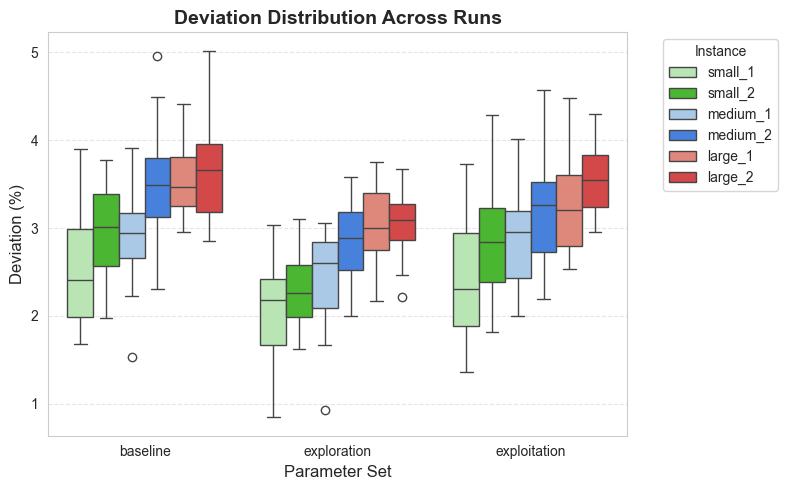

In [802]:
# boxplot - deviation distribution for all instances
plt.figure(figsize=(8,5))

sns.boxplot(
    data=multi_df,
    x="Parameter_Set",
    y="Deviation_%",
    hue="Instance",
    palette=instance_colors
)

plt.title("Deviation Distribution Across Runs", fontsize=14, weight="bold")
plt.ylabel("Deviation (%)", fontsize=12)
plt.xlabel("Parameter Set", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Instance", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


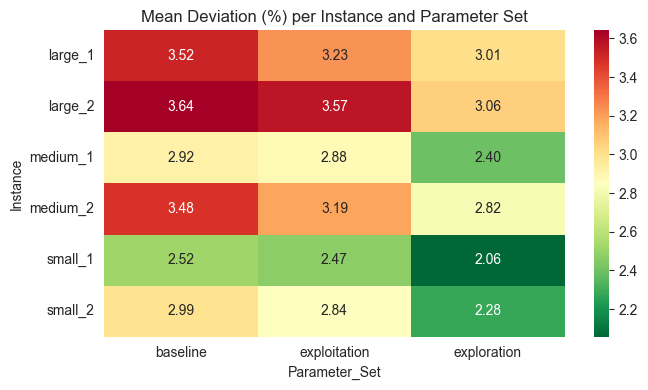

In [803]:
# heatmap of deviation - evaluate performance
pivot = multi_df.pivot_table(
    index="Instance", columns="Parameter_Set", values="Deviation_%", aggfunc="mean")
plt.figure(figsize=(7,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn_r")
plt.title("Mean Deviation (%) per Instance and Parameter Set")
plt.tight_layout()
plt.show()

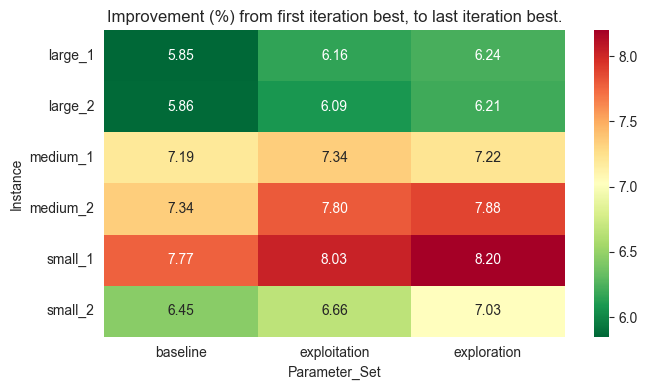

In [804]:
# heatmap of total improvement from baseline to best - evaluate performance
pivot = multi_df.pivot_table(
    index="Instance", columns="Parameter_Set", values="Improvement", aggfunc="mean")
plt.figure(figsize=(7,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn_r")
plt.title("Improvement (%) from first iteration best, to last iteration best.")
plt.tight_layout()
plt.show()

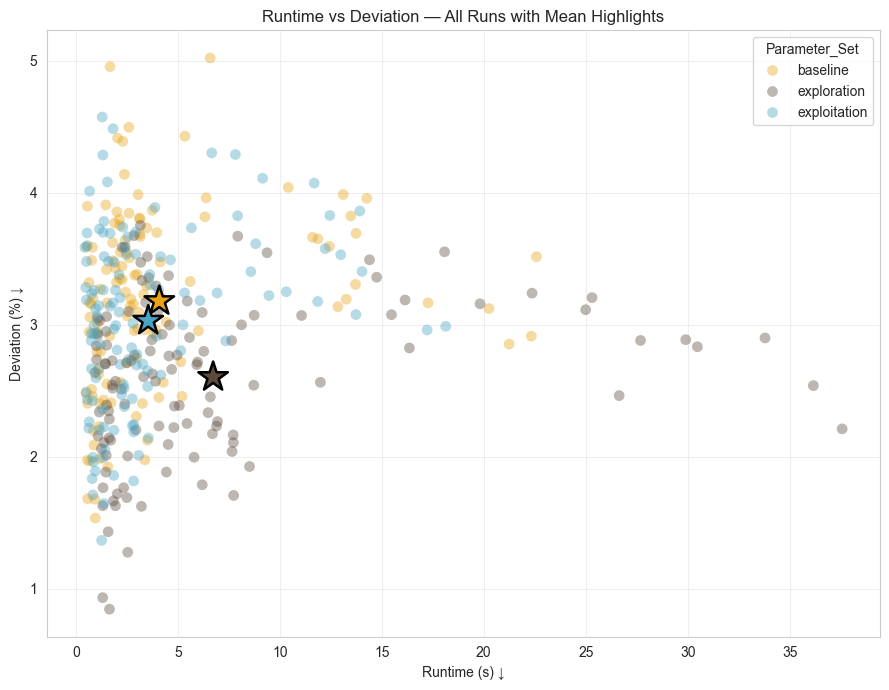

In [808]:
# find mean runtime and deviation per param set
summary = multi_df.groupby('Parameter_Set', as_index=False).agg({
    'Runtime_s': 'mean',
    'Deviation_%': 'mean'
})

plt.figure(figsize=(9,7))

# scatter of all runs
sns.scatterplot(
    data=multi_df,
    x='Runtime_s',
    y='Deviation_%',
    hue='Parameter_Set',
    palette=param_colors,
    alpha=0.4,         # semi-transparent to show overlap
    s=60,
    edgecolor='none'
)

# add means (star)
sns.scatterplot(
    data=summary,
    x='Runtime_s',
    y='Deviation_%',
    hue='Parameter_Set',
    palette=param_colors,
    s=500,
    marker='*',
    edgecolor='black',
    legend=False
)

plt.title('Runtime vs Deviation — All Runs with Mean Highlights')
plt.xlabel('Runtime (s) ↓')
plt.ylabel('Deviation (%) ↓')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


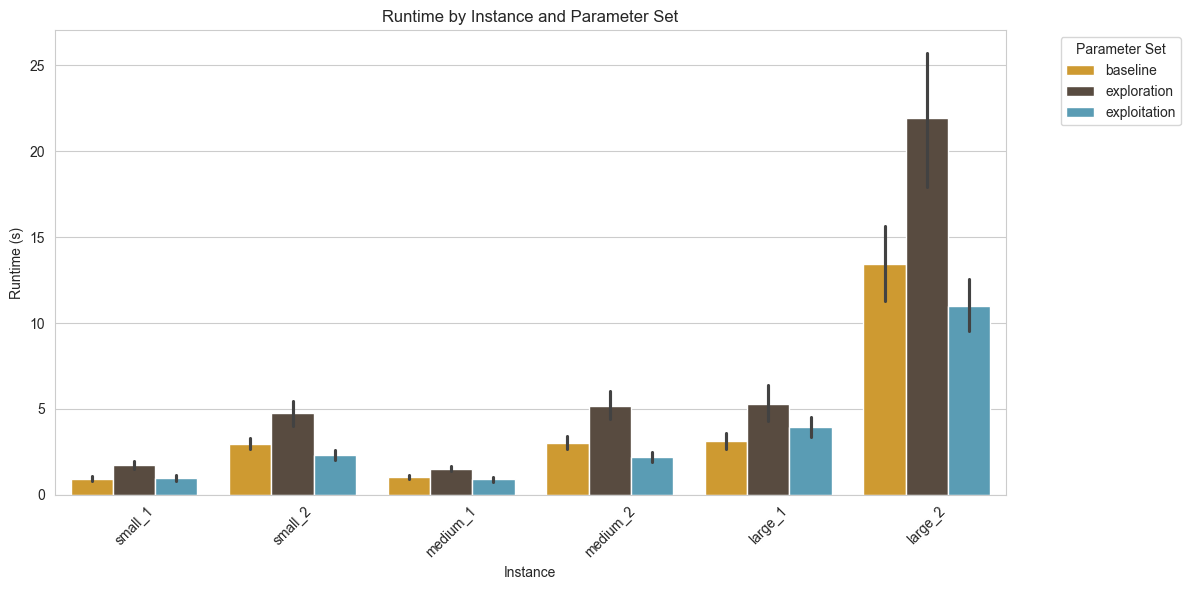

In [806]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=multi_df,
    x='Instance',
    y='Runtime_s',
    hue='Parameter_Set',
    palette=param_colors
)
plt.title('Runtime by Instance and Parameter Set')
plt.xlabel('Instance')
plt.ylabel('Runtime (s)')
plt.xticks(rotation=45)
plt.legend(title='Parameter Set', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


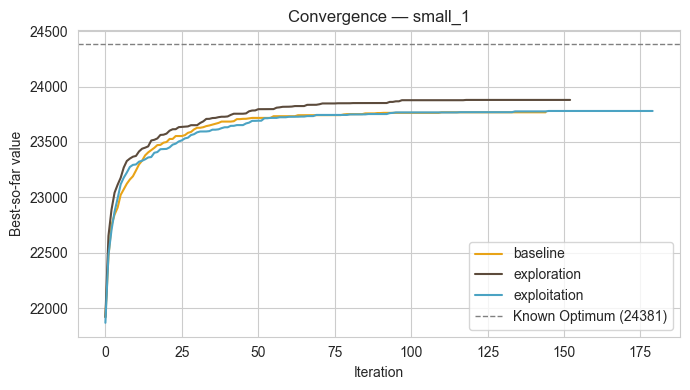

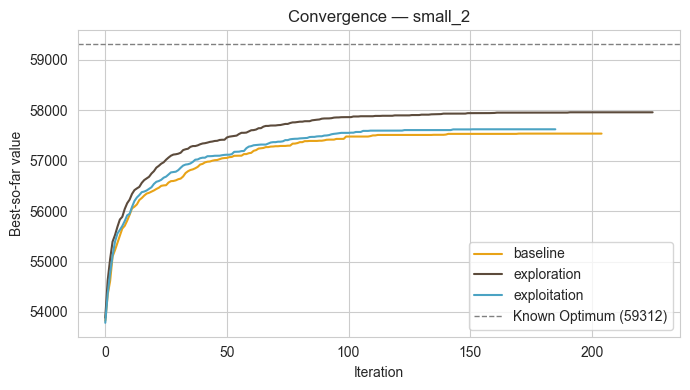

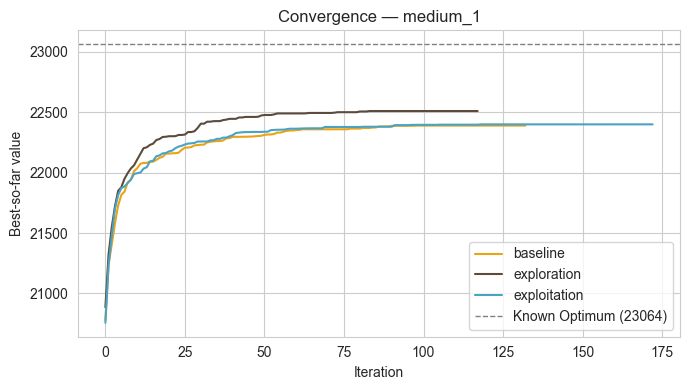

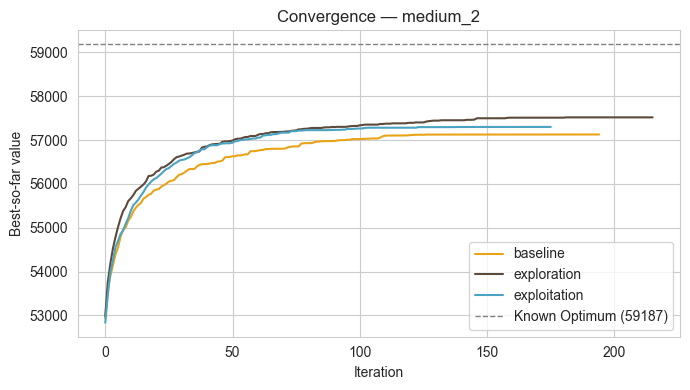

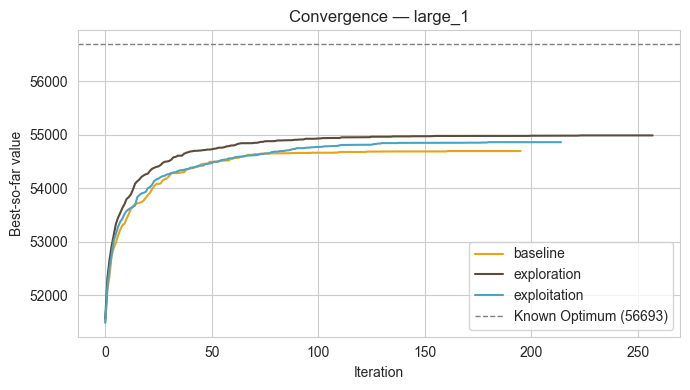

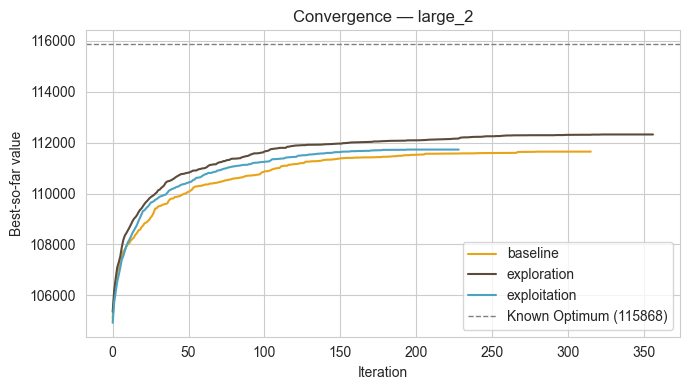

In [807]:
def plot_convergence_by_param(multi_df, instance):
    plt.figure(figsize=(7,4))
    for param in multi_df["Parameter_Set"].unique():
        sub = multi_df[(multi_df.Instance==instance) & (multi_df.Parameter_Set==param)]
        if sub.empty:
            continue
        maxL = max(len(h) for h in sub["Hist_Best"])
        H = np.array([h + [h[-1]]*(maxL-len(h)) for h in sub["Hist_Best"]])
        mean, std = H.mean(axis=0), H.std(axis=0)
        x = np.arange(len(mean))
        plt.plot(x, mean, label=param, color=param_colors[param])

    # known optimum line
    opt_val = known_optima.get(instance, None)
    if opt_val is not None and np.isfinite(opt_val):
        plt.axhline(opt_val, color="gray", linestyle="--", linewidth=1, label=f"Known Optimum ({opt_val:.0f})")

    plt.title(f"Convergence — {instance}")
    plt.xlabel("Iteration")
    plt.ylabel("Best-so-far value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# example:
for inst in multi_df["Instance"].unique():
    plot_convergence_by_param(multi_df, inst)
